In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.express as px
import plotly.graph_objs as go


In [ ]:
# Load the dataset
df = pd.read_excel('/content/drive/MyDrive/customer segmentation/Online Retail.xlsx')

# Inspect the first few rows
print("First 5 Rows of DataFrame:")
print(df.head())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Basic statistics of the dataset
print("\nSummary Statistics:")
print(df.describe())


First 5 Rows of DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Missing Values in Each Column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           

In [ ]:
# Drop rows with missing CustomerID as they cannot be used for customer segmentation
df = df.dropna(subset=['CustomerID'])

# Remove entries where quantity or unit price is zero or negative, as they don't make sense
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Inspect the first few rows
print("First 5 Rows of DataFrame:")
print(df.head())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Basic statistics of the dataset
print("\nSummary Statistics:")
print(df.describe())

First 5 Rows of DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  

Missing Values in Each Column:
InvoiceNo      0
StockCode      0
Description    0
Quantit

In [ ]:
# Recency: Calculate the number of days since the last purchase
latest_date = df['InvoiceDate'].max()
df['Recency'] = (latest_date - df['InvoiceDate']).dt.days

# Frequency: Count the number of transactions for each customer
df_freq = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
df_freq.columns = ['CustomerID', 'Frequency']

# Monetary: Sum of total prices for each customer
df_monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
df_monetary.columns = ['CustomerID', 'Monetary']

# Merge Recency, Frequency, and Monetary into a single DataFrame
rfm_df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Normalize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Convert to DataFrame for easier handling
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("Raw RFM Values:")
print(rfm_df.head())

print("\nNormalized RFM Values:")
print(rfm_scaled_df.head())

Raw RFM Values:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40

Normalized RFM Values:
    Recency  Frequency  Monetary
0  2.334574  -0.425097  8.358668
1 -0.905340   0.354417  0.250966
2 -0.175360  -0.035340 -0.028596
3 -0.735345  -0.425097 -0.033012
4  2.174578  -0.425097 -0.191347


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Silhouette Score: 0.616212846765192


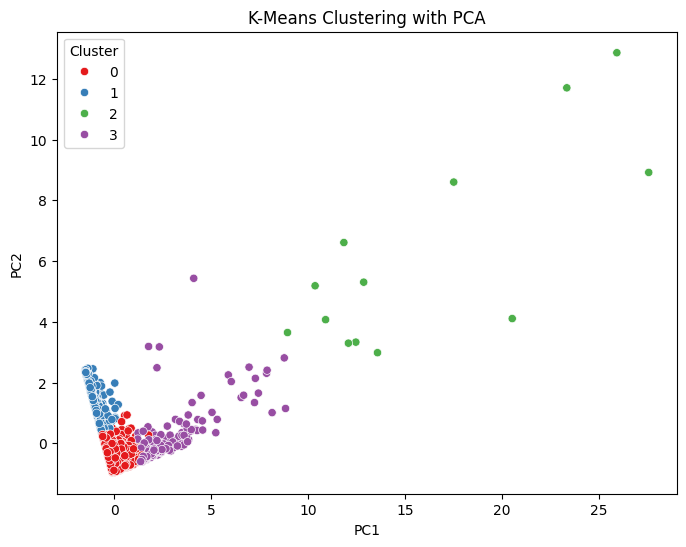

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled_df)
rfm_df['KMeans_Cluster'] = kmeans.labels_

# Evaluate the silhouette score
kmeans_silhouette = silhouette_score(rfm_scaled_df, kmeans.labels_)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Plot K-Means Clusters
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled_df)
rfm_pca_df = pd.DataFrame(data=rfm_pca, columns=['PC1', 'PC2'])
rfm_pca_df['Cluster'] = rfm_df['KMeans_Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=rfm_pca_df, palette='Set1')
plt.title('K-Means Clustering with PCA')
plt.show()


DBSCAN Silhouette Score: 0.8387389400637124


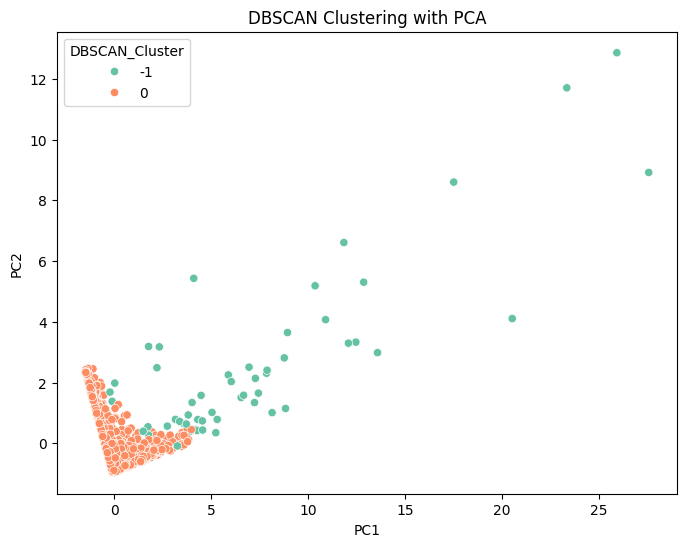

In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm_df['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled_df)

# Evaluate the silhouette score
dbscan_silhouette = silhouette_score(rfm_scaled_df, rfm_df['DBSCAN_Cluster'])
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

# Plot DBSCAN Clusters
rfm_pca_df['DBSCAN_Cluster'] = rfm_df['DBSCAN_Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=rfm_pca_df, palette='Set2')
plt.title('DBSCAN Clustering with PCA')
plt.show()


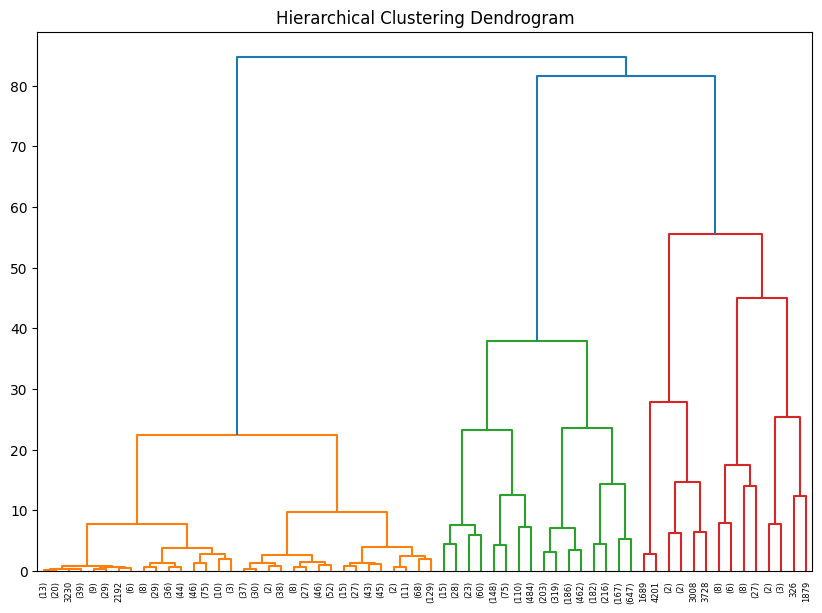

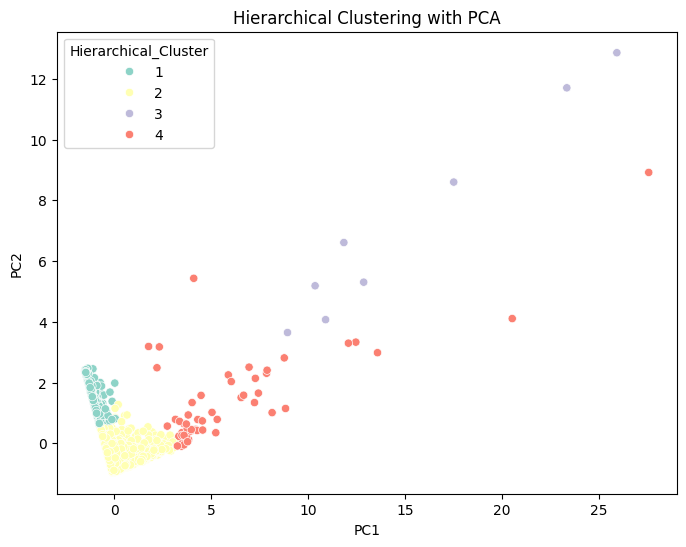

In [ ]:
# Apply hierarchical clustering
linked = linkage(rfm_scaled_df, 'ward')
rfm_df['Hierarchical_Cluster'] = fcluster(linked, 4, criterion='maxclust')

# Plot Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Plot Hierarchical Clusters
rfm_pca_df['Hierarchical_Cluster'] = rfm_df['Hierarchical_Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Hierarchical_Cluster', data=rfm_pca_df, palette='Set3')
plt.title('Hierarchical Clustering with PCA')
plt.show()


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Assuming you have already performed PCA and have rfm_pca_df with 'PC1' and 'PC2'

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_pca_df[['PC1', 'PC2']])
rfm_pca_df['KMeans_Cluster'] = kmeans.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(rfm_pca_df[['PC1', 'PC2']])
rfm_pca_df['DBSCAN_Cluster'] = dbscan.labels_

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3).fit(rfm_pca_df[['PC1', 'PC2']])
rfm_pca_df['Hierarchical_Cluster'] = hierarchical.labels_

# Re-plot after adding clusters
# Interactive visualization with Plotly
fig = px.scatter(rfm_pca_df, x='PC1', y='PC2', color='KMeans_Cluster', title='K-Means Clustering with PCA')
fig.show()

fig = px.scatter(rfm_pca_df, x='PC1', y='PC2', color='DBSCAN_Cluster', title='DBSCAN Clustering with PCA')
fig.show()

fig = px.scatter(rfm_pca_df, x='PC1', y='PC2', color='Hierarchical_Cluster', title='Hierarchical Clustering with PCA')
fig.show()




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Summary of the clustering results
print("Cluster Counts:")
print(rfm_df['KMeans_Cluster'].value_counts())

print("\nRFM Values for Each Cluster:")
rfm_summary = rfm_df.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(rfm_summary)

# Additional insights and recommendations can be derived from these clusters, such as targeting high-value customers, reactivating lost customers, etc.


Cluster Counts:
KMeans_Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64

RFM Values for Each Cluster:
   KMeans_Cluster     Recency  Frequency       Monetary
0               0   42.702685   3.682711    1359.049284
1               1  247.075914   1.552015     480.617480
2               2    6.384615  82.538462  127338.313846
3               3   14.500000  22.333333   12709.090490
